In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [70]:
# hit-file loader
def load_hit_graph(file):
    with np.load(file, allow_pickle=True) as f:
        # print(list(f.keys()))
        hits = f['hits']
        scaled_hits = f['scaled_hits']
        hits_xyz = f['hits_xyz']
        noise_label = f['noise_label']
        layer_id = f['layer_id']
        edge_index = f['edge_index']
        pid = f['pid']
        n_hits = f['n_hits']
        n_tracks =f ['n_tracks']
        trigger_flag = f['trigger']
        ip = f['ip']
        psv = f['psv'] # secondary vertex
        p_momentum = f['p_momentum']
        e = f['e']
    return hits, scaled_hits, hits_xyz, noise_label, layer_id, edge_index, pid, n_hits, n_tracks, trigger_flag, ip, psv, p_momentum, e


In [3]:
def get_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))
    
def rule_always_true(track, ip):
    return track['TrackID'] != -1

def rule1(track, ip):
    return track['TrackID'] > 0

def rule2(track, ip):
    momentum = track['TrackMomentum']
    return track['TrackID'] > 0 and momentum[0] ** 2 + momentum[1] ** 2 >= 0.04

def rule3(track, ip):
    momentum = track['TrackMomentum']
    track_origin = track['OriginVertexPoint']
    d = get_distance(track_origin, ip)
    return track['TrackID'] > 0 and momentum[0] ** 2 + momentum[1] ** 2 >= 0.04 and d > 0.00001 and d < 1

In [39]:
type = '/trigger'
n_files = 100

hits_input_dir = '/home1/tingtingxuan/Data/tracking_inference_INTTclustered' + type
filenames = sorted([os.path.join(hits_input_dir, f) for f in os.listdir(hits_input_dir) if f.startswith('event')])[:n_files]

In [5]:
file_index = 0
filename = filenames[file_index]

In [6]:
hits, scaled_hits, hits_xyz, noise_label, layer_id, edge_index, pid, n_hits, n_tracks, trigger_flag, ip, psv, p_momentum, e = load_hit_graph(filename)

['hits', 'scaled_hits', 'hits_xyz', 'noise_label', 'layer_id', 'edge_index', 'pid', 'n_hits', 'n_tracks', 'trigger', 'ip', 'psv', 'p_momentum', 'e']


In [8]:
pid_set = set(pid)
print(pid_set)

{35, 36, 37, 6, 4, 8, 9, 42, 11, 10, 47, 48, 30, -902, -1, 31}


In [20]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi
def select_segments(hits1, hits2, phi_slope_max, z0_max, all=False):
    """
    Construct a list of selected segments from the pairings
    between hits1 and hits2, filtered with the specified
    phi slope and z0 criteria.

    Returns: pd DataFrame of (index_1, index_2), corresponding to the
    DataFrame hit label-indices in hits1 and hits2, respectively.
    """
    # Start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    if all:
        return hit_pairs[['index_1', 'index_2']]
    # Compute line through the points
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    # Filter segments according to criteria
    good_seg_mask = (phi_slope.abs() < phi_slope_max) & (z0.abs() < z0_max)
    return hit_pairs[['index_1', 'index_2']][good_seg_mask]

In [29]:
import pandas as pd
from icecream import ic

In [15]:
hits_list = []
for i in range(hits_xyz.shape[0]):
    hit = {}
    hit['x'], hit['y'], hit['z'] = hits_xyz[i, :]
    hit['pid'] = pid[i]
    hit['layer_id'] = layer_id[i]
    hit['evtid'] = 0
    hits_list.append(hit)
hits_df=pd.DataFrame(hits_list)


In [18]:
r = np.sqrt(hits_df.x**2 + hits_df.y**2)
phi = np.arctan2(hits_df.y, hits_df.x)
hits_df = hits_df.assign(r=r, phi=phi)

layer_pairs = np.array([(0,1), (1,2), (2,3), (4,5), (2,4), (3,5), (3,6), (4,6)])
layer_groups = hits_df.groupby('layer_id')
segments = []
for (layer1, layer2) in layer_pairs:
    # Find and join all hit pairs
    try:
        hits1 = layer_groups.get_group(layer1)
        hits2 = layer_groups.get_group(layer2)
    # If an event has no hits on a layer, we get a KeyError.
    # In that case we just skip to the next layer pair
    except KeyError as e:
        print('skipping empty layer: %s' % e)
        continue
    # Construct the segments
    segments.append(select_segments(hits1, hits2, phi_slope_max=0.03, z0_max=200))
# Combine segments from all layer pairs
try:
    segments = pd.concat(segments)
except:
    print("can't do concatenate!", filename)

edge_index = np.transpose(np.array(segments))


In [26]:
def get_edge_index(hits_df, threshold):
    layer_pairs = np.array([(0,1), (1,2), (2,3), (4,5), (2,4), (3,5), (3,6), (4,6)])
    layer_groups = hits_df.groupby('layer_id')
    segments = []
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        try:
            hits1 = layer_groups.get_group(layer1)
            hits2 = layer_groups.get_group(layer2)
        # If an event has no hits on a layer, we get a KeyError.
        # In that case we just skip to the next layer pair
        except KeyError as e:
            print('skipping empty layer: %s' % e)
            continue
        # Construct the segments
        segments.append(select_segments(hits1, hits2, phi_slope_max=threshold, z0_max=200))
    # Combine segments from all layer pairs
    try:
        segments = pd.concat(segments)
    except:
        print("can't do concatenate!", filename)

    edge_index = np.transpose(np.array(segments))
    return edge_index

In [86]:
def get_confusion_matrix_for_one_event_with_threshold(filename, threshold):
    hits, scaled_hits, hits_xyz, noise_label, layer_id, edge_index, pid, n_hits, n_tracks, trigger_flag, ip, psv, p_momentum, e = load_hit_graph(filename)
    hits_list = []
    for i in range(hits_xyz.shape[0]):
        hit = {}
        hit['x'], hit['y'], hit['z'] = hits_xyz[i, :]
        hit['pid'] = pid[i]
        hit['layer_id'] = layer_id[i]
        hit['evtid'] = 0
        hits_list.append(hit)
    hits_df=pd.DataFrame(hits_list)
    r = np.sqrt(hits_df.x**2 + hits_df.y**2)
    phi = np.arctan2(hits_df.y, hits_df.x)
    hits_df = hits_df.assign(r=r, phi=phi)

    # for id in set(hits_df['pid']):
    #     print(id, hits_df[hits_df['pid'] == id].shape)
    
    edge_index = get_edge_index(hits_df, threshold)
    
    start, end = edge_index
    n_edge = edge_index.shape[1]
    momentum_mask = [m is not None and m[0] ** 2 + m[1] ** 2 > 0.04 for m in p_momentum[start]]
    tp = np.sum(np.logical_and(np.logical_and(pid[start]>0, pid[start] == pid[end]), momentum_mask))

    all_edge_index = get_edge_index(hits_df, threshold=10)
    start, end = all_edge_index
    momentum_mask = [m is not None and m[0] ** 2 + m[1] ** 2 > 0.04 for m in p_momentum[start]]
    ap = np.sum(np.logical_and(np.logical_and(pid[start]>0, pid[start] == pid[end]), momentum_mask))

    return tp, ap, n_edge



In [87]:
tp, ap, n_edge = get_confusion_matrix_for_one_event_with_threshold(filenames[8], 0.03)
ic(tp, ap, n_edge)

ic| tp: 17, ap: 17, n_edge: 19


(17, 17, 19)

In [89]:
def get_recall_precision_of_edges(threshold):
    recall = []
    precision = []
    for file in filenames:
        tp, ap, n_edge = get_confusion_matrix_for_one_event_with_threshold(file, threshold)
        recall.append(tp/ap)
        precision.append(tp/n_edge)
    return np.mean(recall), np.mean(precision)

In [96]:
recalls = []
precisions = []
for threshold in np.arange(0.01, 0.11, 0.01):
    recall, precision = get_recall_precision_of_edges(threshold)
    recalls.append(recall)
    precisions.append(precision)

skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty layer: 4
skipping empty l

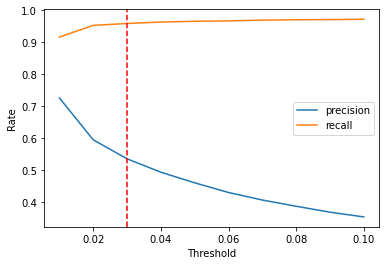

In [116]:
# fig, axs = plt.subplots(1, 2, figsize=(16,4))
thresholds = list(np.arange(0.01, 0.11, 0.01))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.axvline(x=0.03, c='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.savefig('/home1/tingtingxuan/physics-trigger-graph-level-prediction/analysis/plots/threshold')